In [1]:
import glob
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook
from sklearn.preprocessing import MultiLabelBinarizer

pd.options.display.float_format = '{:,.2f}'.format

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
# Para o Modelo
import tensorflow as tf
import keras
from keras import backend as K
from keras.applications.vgg19 import VGG19
from keras.optimizers import *
from keras.callbacks import *
from keras.metrics import top_k_categorical_accuracy
from keras.utils import to_categorical
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler

Using TensorFlow backend.


# Processando os dados

## Gerados com Penelope

In [3]:
files =  glob.glob("../dados_v[4-5]/*.dat")

In [4]:
len(files)

758

In [3]:
def le_performance_report(filename):
    # 164000
    # Performance report
    #   Random seeds:
    #   1800926990
    #   1275941380
    #   No. of histories simulated [N]:
    #            10000000.
    #   CPU time [t] (s):
    #    3.28417E+01
    #   Speed (histories/s):
    #    3.04491E+05
    #   Average uncertainty (above 1/2 max score) in % [uncert]:
    #    1.27128E-01
    #   Intrinsic efficiency [N*uncert^2]^-1:
    #    6.18758E-06
    #   Absolute efficiency [t*uncert^2]^-1:
    #    1.88406E+00
    
    with open(filename, "r") as f:
        linhas = f.readlines()
    try:
        return float(linhas[16400+7][1:])
    except:
        return float(linhas[16400+6][1:])

def carrega_dados(filename, n_particulas=1.0e07):
    data = {
        'Elow(eV)' : [],
        'Emiddle(eV)' : [],
        'counts(1/eV/hist)' : [],
        '+-2sigma':[],
        'nbin' : []
    }

    linha_de_dados = False
    with open(filename, "r") as f:
        for line in f:
            if line[0] == '#':
                linha_de_dados = False
            else:
                linha_de_dados = True

            if linha_de_dados:
                aux = line.split(' ')
                if len(aux) == 2:
                    break

                data['Elow(eV)'].append(np.fromstring(aux[2], dtype=np.float64, sep=',')[0])
                data['Emiddle(eV)'].append(np.fromstring(aux[4], dtype=np.float64, sep=',')[0])
                q = np.fromstring(aux[6], dtype=np.float64, sep=',')[0]
                data['counts(1/eV/hist)'].append(q)
                data['+-2sigma'].append(np.fromstring(aux[8], dtype=np.float64, sep=',')[0])
                nbin = np.fromstring(aux[9], dtype=np.int, sep=',')[0]
                data['nbin'].append(nbin)      

    df = pd.DataFrame.from_dict(data)
    df['counts'] = df['counts(1/eV/hist)'].values * n_particulas * 1 / ((df['Elow(eV)'].shift(-1).fillna(0) - df['Elow(eV)']) / df['nbin'])
    df['counts'] = df['counts']#.astype(np.uint8)
    df['counts'][0:20] = 0
    df['E'] = df['Elow(eV)'] / 1e3
    return df.loc[0:16383]

In [6]:
tempo_segundos = 0

for file_ in files:
    tempo_segundos += le_performance_report(file_)
    
print("Total de tempo de CPU utilizado: {0} dias".format(tempo_segundos / 60 / 60 / 24))

Total de tempo de CPU utilizado: 377.71992948148136 dias


In [4]:
energias_iniciais_multicanal = ['-1', '1', '250', '400', '150', '300', '0']
#energias_iniciais_multicanal = ['0-01.dat']
#energias_iniciais_multicanal = ['0-01.dat', '5-0.dat', '10-0.dat', '30-0.dat', '40-0.dat']
#energias_iniciais_multicanal = ['0-01.dat']

In [5]:
nomes_nuclideos = {
    'Am-241': 0,
    'Ba-133': 1,
    'Cd-109': 2,
    'Co-57': 3,
    'Co-60': 4,
    'Cs-137': 5,
    'Eu-152': 6,
    'Mn-54': 7,
    'Na-22': 8,
    'Pb-210': 9
}

binarizer = MultiLabelBinarizer()
binarizer.fit([list(nomes_nuclideos.keys())])
binarizer.classes_

array(['Am-241', 'Ba-133', 'Cd-109', 'Co-57', 'Co-60', 'Cs-137', 'Eu-152',
       'Mn-54', 'Na-22', 'Pb-210'], dtype=object)

In [6]:
# Cd-109_41cm_1-0e08estories_0-01.dat
dados_por_energia_inicial_multicanal = dict()

for energia_inicial_multicanal in energias_iniciais_multicanal:
    dados_por_energia_inicial_multicanal[energia_inicial_multicanal] = []
    
    for file_ in tqdm_notebook(files):
        if not file_.endswith('_'+energia_inicial_multicanal+'.dat'):
            continue
        
        partes = file_.split("/")[2].replace(".dat", "").split("_")
        nuclideo = partes[0]        
        distancia = partes[1]
        
        n_particulas_simulacao = float(partes[2].replace('estories','').replace('-','.'))
        
        # diferentes atividades
        for n_particulas in [1e3, 1e6, 1e9, 3e3, 3e6, 3e9, 8e3, 8e6, 8e9, n_particulas_simulacao]:
        
            dados_ = carrega_dados(file_, n_particulas)

            label_ = binarizer.transform([[nuclideo]])

            #Cria o label para o total de contagens do radionuclídeo
            #total_counts = np.zeros(label_.shape)
            #total_counts[0][np.argmax(label_)] = np.sum(dados_.counts.values)

            atividade = np.zeros(label_.shape)
            atividade[0][np.argmax(label_)] = n_particulas
            
            dados_por_energia_inicial_multicanal[energia_inicial_multicanal].append({
                'X' : dados_.counts.values,
                'n' : atividade,
                'y': label_,
                #'y_count' : total_counts,
                'd': distancia,
                'e': energia_inicial_multicanal
            })

NameError: name 'files' is not defined

In [11]:
a = 0
for k in dados_por_energia_inicial_multicanal:
    print(k, len(dados_por_energia_inicial_multicanal[k]))
    a += len(dados_por_energia_inicial_multicanal[k])
a

-1 400
1 1200
250 1190
400 1200
150 1200
300 1200
0 1190


7580

## Leituras experimentais da GRR

In [7]:
def obtem_dados_dos_canais(linhas):
    dados = []
    pode_comecar = False
    for linha in linhas:
        if linha == "A004USERDEFINED                                                     \n":
            pode_comecar = True
            continue
        if pode_comecar:
            aux = linha.strip().split()
            if int(aux[1]) % 5:
                print("oi!")
            dados.extend([float(x) for x in aux[2:]])
    return dados[1:]

In [13]:
arquivos = ['Am-241 - BG.IEC', 'Ba-133 - BG.IEC', 'Cd-109 - BG.IEC', 'Co-57 - BG.IEC', 'Co-60 - BG.IEC',
            'Cs-137 - BG.IEC', 'Eu-152 - BG.IEC', 'Mn-54 - BG.IEC', 'Na-22 - BG.IEC', 'Pb-210 - BG.IEC',]

df_nuclideos = dict()
img_espectros = dict()
img_convertidos = dict()
images = dict()

for arquivo in arquivos:
    print(arquivo)
    dados = []

    with open('/export/ipen/artigo/ICDA-3/Espectros/Experimentos/17-Maio-2018/Espectros/{0}'.format(arquivo), 'r') as f:
        dados = f.readlines()
    dados = obtem_dados_dos_canais(dados)
    df = pd.DataFrame({'channel': range(0, len(dados)), 'counts' : dados})
    df_nuclideos[arquivo] = df.copy()
    img_convertidos[arquivo] = np.array(dados).reshape((128, 128)).copy()
    images[arquivo.split(' ')[0]] = np.array(dados).reshape((128, 128)).copy()

Am-241 - BG.IEC
Ba-133 - BG.IEC
Cd-109 - BG.IEC
Co-57 - BG.IEC
Co-60 - BG.IEC
Cs-137 - BG.IEC
Eu-152 - BG.IEC
Mn-54 - BG.IEC
Na-22 - BG.IEC
Pb-210 - BG.IEC


In [8]:
arquivo_por_nome = { b : b.split()[0] for a, b in enumerate(list(img_convertidos.keys()))}
nome_por_arquivo = { b.split()[0] : b for a, b in enumerate(list(img_convertidos.keys()))}

id_para_radionuclideos = { a : b.split()[0] for a, b in enumerate(list(img_convertidos.keys()))}
radionuclideos = { b.split()[0] : a for a, b in enumerate(list(img_convertidos.keys()))}
arquivo_por_nome, nome_por_arquivo, id_para_radionuclideos, radionuclideos

NameError: name 'img_convertidos' is not defined

In [15]:
#plt.plot(np.random.poisson(1e5, (128, 128)))
#plt.plot(np.random.normal(1, 0.1**0.5, (128, 128)))

In [9]:
def add_noise(image):
    #if random.random() <= 0.5:
    #    return image.reshape((128, 128, 1))
    row,col = image.shape
    mean = 1 #np.mean(image)
    var = 0.1 #random.random() #
    sigma = var**0.5
    gauss = np.random.normal(mean, sigma, (row,col))
    gauss = gauss.reshape(row, col)
    noisy = image + gauss
    if np.random.random() > 0.3:
        #increase de count rate by a random factor
        noisy += noisy * (1 + np.random.random())
    return noisy.reshape((128, 128, 1)) #/ np.max(noisy) # normalizando pelo valor máximo


#def gera_imagem_combinada_experimental(dicionario_imagens, n_combinacoes=3):
#    assert n_combinacoes <= 10, "No máximo 10 combinações"
#    nuclei_idx = np.random.choice(10, n_combinacoes, replace=False).tolist()[0]
#    label = to_categorical(nuclei_idx, 10)
#    img = np.sum([add_noise(dicionario_imagens[id_para_radionuclideos[nuclei_idx]])], axis=0)
#    counts = to_categorical(nuclei_idx, 10)
#    counts[nuclei_idx] = np.sum(img)
#    
#    return img, label, counts

def gera_imagem_combinada_experimental(dicionario_imagens,
                                       n_combinacoes=1):
    
    assert n_combinacoes <= 10, "No máximo 10 combinações"
    
    a = np.random.choice(10, n_combinacoes, replace=False).tolist()
    labels = np.sum([to_categorical(x, 10) for x in a], axis=0)
    noise_img = [add_noise(dicionario_imagens[id_para_radionuclideos[x]]) for x in a]
    img = np.sum(noise_img, axis=0)
    
    counts = np.zeros((10,))
    for idx, item in enumerate(a):
        counts[item] = np.sum(noise_img[idx])
    
    while np.max(labels) > 1: # temos nuclideo repetido
        labels[0][np.argmax(labels[0])] = 1
    
    return img, labels, counts


# Gerando conjunto de treino e validação

## Com os dados experimentais

In [17]:
X = []
y = []
y_counts = []

In [18]:
# gerando imagens com mais de um espectro
n_combinacoes = [1, 2, 3, 4]
for n_combinacao in n_combinacoes:
    for i in range(500):
        img, label, counts = gera_imagem_combinada_experimental(images, n_combinacao)
        X.append(img)
        y.append(label)
        y_counts.append(counts)

In [19]:
len(X), len(y), len(y_counts)

(2000, 2000, 2000)

## Com os dados gerados pelo PENELOPE

In [10]:
def gera_imagem_combinada_penelope(dicionario_imagens, n_combinacoes=3):
    assert n_combinacoes <= 10, "No máximo 10 combinações"

    aux = np.random.choice(dicionario_imagens, n_combinacoes, replace=False)
    #print(aux)
    labels = np.sum([x['y'] for x in aux], axis=0)
    counts = np.sum([x['n'] for x in aux], axis=0)
    #counts = np.sum([x['y_count'] for x in aux], axis=0)
    values = np.sum([x['X'] for x in aux], axis=0)
    
    while np.max(labels) > 1: # temos nuclideo repetido
        labels[0][np.argmax(labels[0])] = 1
    
    return values, labels, counts

### Gera espectros com mais de um radionuclideo

Até 4 no mesmo espectro

In [21]:
n_combinacoes = [2, 3, 4]
novos_dados = dict()

for key in energias_iniciais_multicanal:
    novos_dados[key] = []
    for n_ in n_combinacoes:
        for i in range(500):
            values, labels, counts = gera_imagem_combinada_penelope(dados_por_energia_inicial_multicanal[key],
                                                  n_)
            novos_dados[key].append({'X' : values,
                                     'y': labels,
                                     'n': counts})

In [25]:
for key in energias_iniciais_multicanal:
    for item in dados_por_energia_inicial_multicanal[key]:
        X.append(list(item.values())[0].reshape((128, 128)))
        y.append(item['y'][0])
        y_counts.append(item['n'][0])

In [26]:
for key in energias_iniciais_multicanal:
    for item in novos_dados[key]:
        X.append(list(item.values())[0].reshape((128, 128)))
        y.append(item['y'][0])
        y_counts.append(item['n'][0])

In [27]:
len(X), len(y), len(y_counts)

(20080, 20080, 20080)

In [28]:
!rm -rf ./dados_v1_2
!mkdir ./dados_v1_2
np.save("./dados_v1_2/X.npy", [x.reshape((128,128,1)) for x in X])
np.save("./dados_v1_2/y.npy", y)
np.save("./dados_v1_2/y_counts.npy", y_counts)

In [11]:
X = np.load("./dados_v1_2/X.npy")
y = np.load("./dados_v1_2/y.npy")
y_counts = np.load("./dados_v1_2/y_counts.npy")

# Modelo

## Dividindo os dados em treino e teste

In [12]:
#scaler = StandardScaler()
#scaler.fit(y_counts)

X_train, X_test, y_train, y_test = train_test_split(X, list(zip(y, np.log(np.array(y_counts) + 1))),
                                                    test_size=0.30,
                                                    random_state=42)

In [13]:
len(X_train), len(X_test), len(y_train), len(y_test)

(14056, 6024, 14056, 6024)

In [14]:
from keras.utils import Sequence

In [15]:
class EspectraSequence(Sequence):

    def __init__(self, x_set, y_set, y_set_count, batch_size):
        self.x, self.y, self.y_set_count = x_set, y_set, y_set_count
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y_count = self.y_set_count[idx * self.batch_size:(idx + 1) * self.batch_size]

        y_ = {'predictions_nuclei': np.array(batch_y, dtype=np.float32),
              'predictions_counts': np.array(batch_y_count)}
        
        return np.array([x.reshape((128, 128, 1)) for x in batch_x]), y_

In [16]:
s = EspectraSequence(X_train, [x[0] for x in y_train], [x[1] for x in y_train], batch_size=8)

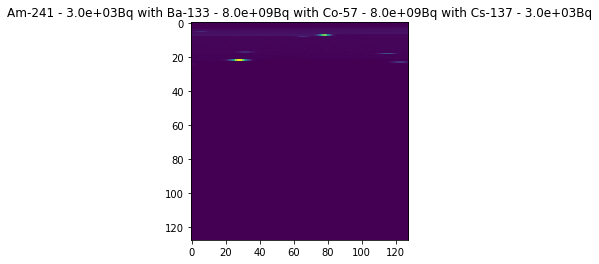

In [17]:
a, b = s[2]
c = b['predictions_counts']
b = b['predictions_nuclei']
plt.imshow(a[0].reshape((128, 128)))
title_data = list(zip(binarizer.inverse_transform(np.array([b[0]]))[0], np.exp(c[0])[np.array([b[0]]).astype(np.bool)[0]]))
plt.title(" with ".join(["{} - {:.1e}Bq".format(x[0], x[1]) for x in title_data]))
plt.show()

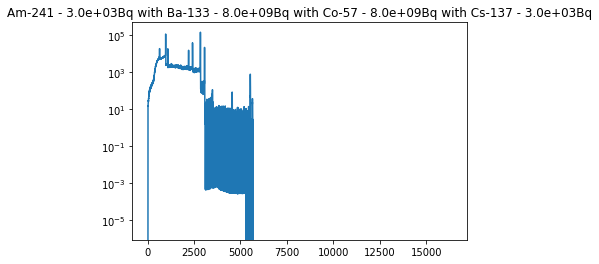

In [18]:
title_data = list(zip(binarizer.inverse_transform(np.array([b[0]]))[0], np.exp(c[0])[np.array([b[0]]).astype(np.bool)[0]]))
plt.title(" with ".join(["{} - {:.1e}Bq".format(x[0], x[1]) for x in title_data]))
plt.plot(a[0].reshape(-1))
plt.yscale("log")
plt.show()

In [19]:
def accuracy_score_wrapper(label, pred):
    threshold = .95
    label = (label >= threshold).astype(np.uint8)
    pred = (pred >= threshold).astype(np.uint8)
    return np.float32(accuracy_score(label, pred))

def my_accuracy_score(label, pred):
    metric_value = tf.compat.v1.py_func(accuracy_score_wrapper, [label, pred], tf.float32)
    return metric_value

In [20]:
K.clear_session()
import keras
vgg_model = VGG19(include_top=False,
                  weights=None,
                  input_shape=(128, 128, 1),
                  classes=10)

x = keras.layers.Flatten()(vgg_model.output)
x = keras.layers.Dense(4096, activation='relu')(x)
x = keras.layers.Dense(4096, activation='relu')(x)

x1 = keras.layers.Flatten()(vgg_model.output)
x1 = keras.layers.Dense(4096, activation='relu')(x1)
x1 = keras.layers.Dense(4096, activation='relu')(x1)

pred_nuclei = keras.layers.Dense(10, activation='sigmoid', name="predictions_nuclei")(x)

#pred_counts = keras.layers.Dense(4096, activation='elu')(x1)
#pred_counts = keras.layers.Dense(2048, activation='elu')(pred_counts)
pred_counts = keras.layers.Dense(10, activation=None, name="predictions_counts")(x1)

#se a previsão do modelo for menor que zero, a gente zera a saída, afinal de contas
#não existe atividade 0 bq :P
#pred_counts = keras.layers.Lambda(lambda x: tf.where(x < 0, tf.zeros_like(x), x),
#                                 name="predictions_counts")(pred_counts)

model = keras.models.Model(vgg_model.input, [pred_nuclei, pred_counts])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 128, 128, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 128, 128, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 64, 64, 64)   0           block1_conv2[0][0]               
____________________________________________________________________________________________

In [21]:
learning_rate = 1e-4
epochs = 250
batch_size = 8
steps_per_epoch = len(X_train) // batch_size + 1
validation_steps = len(X_test) // batch_size + 1

In [22]:
opt = SGD(lr=learning_rate,
          nesterov=False,
          momentum=0.9) # keras.optimizers.RMSprop(0.001)

model.compile(optimizer=opt,
              loss={
                  'predictions_nuclei': 'binary_crossentropy',
                  'predictions_counts': 'mean_squared_error'
              },
              metrics={
                  'predictions_nuclei': [my_accuracy_score, 'accuracy'],
                  'predictions_counts': ['mean_squared_error', 'mean_absolute_error']
              }
             )

Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    


In [23]:
!nvidia-smi

Sat Jul  4 21:29:09 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.100      Driver Version: 440.100      CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce RTX 2060    Off  | 00000000:01:00.0  On |                  N/A |
| N/A   48C    P2    28W /  N/A |   5729MiB /  5926MiB |      1%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [24]:
!rm -rf ./logsv1_2
!mkdir ./logsv1_2

In [71]:
"""

nao funciona bem com multiplas saidas...

class TensorBoardWrapper(keras.callbacks.TensorBoard):
    '''Sets the self.validation_data property for use with TensorBoard callback.'''

    def __init__(self, batch_gen, nb_steps, **kwargs):
        super(TensorBoardWrapper, self).__init__(**kwargs)
        self.batch_gen = batch_gen # The generator.
        self.nb_steps = nb_steps   # Number of times to call next() on the generator.

    def on_epoch_end(self, epoch, logs):
        # Fill in the `validation_data` property. Obviously this is specific to how your generator works.
        # Below is an example that yields images and classification tags.
        # After it's filled in, the regular on_epoch_end method has access to the validation_data.
        imgs, tags = None, None
        for s in range(self.nb_steps):
            ib, tb = next(self.batch_gen)
            if imgs is None and tags is None:
                imgs = np.zeros(((self.nb_steps * ib.shape[0],) + ib.shape[1:]), dtype=np.float32)
                tags = np.zeros(((self.nb_steps * tb.shape[0],) + tb.shape[1:]), dtype=np.uint8)
            imgs[s * ib.shape[0]:(s + 1) * ib.shape[0]] = ib
            tags[s * tb.shape[0]:(s + 1) * tb.shape[0]] = tb
        self.validation_data = [imgs, tags, np.ones(imgs.shape[0]), 0.0]
        return super(TensorBoardWrapper, self).on_epoch_end(epoch, logs)
"""

"\n\nnao funciona bem com multiplas saidas...\n\nclass TensorBoardWrapper(keras.callbacks.TensorBoard):\n    '''Sets the self.validation_data property for use with TensorBoard callback.'''\n\n    def __init__(self, batch_gen, nb_steps, **kwargs):\n        super(TensorBoardWrapper, self).__init__(**kwargs)\n        self.batch_gen = batch_gen # The generator.\n        self.nb_steps = nb_steps   # Number of times to call next() on the generator.\n\n    def on_epoch_end(self, epoch, logs):\n        # Fill in the `validation_data` property. Obviously this is specific to how your generator works.\n        # Below is an example that yields images and classification tags.\n        # After it's filled in, the regular on_epoch_end method has access to the validation_data.\n        imgs, tags = None, None\n        for s in range(self.nb_steps):\n            ib, tb = next(self.batch_gen)\n            if imgs is None and tags is None:\n                imgs = np.zeros(((self.nb_steps * ib.shape[0],)

In [25]:
gerador_treino = EspectraSequence(X_train, [x[0] for x in y_train], [x[1] for x in y_train], batch_size=batch_size)
#gerador_imagens(X_train, y_train, batch_size=batch_size)

gerador_validacao = EspectraSequence(X_test, [x[0] for x in y_test], [x[1] for x in y_test], batch_size=batch_size)
#gerador_imagens(X_test, y_test, batch_size=batch_size)

es = keras.callbacks.EarlyStopping(monitor='val_loss',
                                   mode='min',
                                   patience=20)

tb = keras.callbacks.TensorBoard(
    log_dir='./logsv1_2',
    histogram_freq=0,
    #batch_size=32,
    write_graph=True,
    #batch_gen=gerador_validacao,
    #nb_steps=validation_steps,
    update_freq='epoch')

#EspectraSequence(X_train, [x[0] for x in y_train], [x[1] for x in y_train], batch_size=8)

callbacks = [es, tb]

hist = model.fit_generator(generator=gerador_treino,
                           steps_per_epoch=steps_per_epoch,
                           epochs=epochs,
                           verbose=2,
                           callbacks=callbacks,
                           validation_data=gerador_validacao, #(x_train_val, y_train_val),
                           validation_steps=validation_steps,
                           shuffle=True)


Epoch 1/250


UnknownError: 2 root error(s) found.
  (0) Unknown:  Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[node block1_conv1/convolution (defined at /home/andre/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3009) ]]
	 [[predictions_nuclei/Sigmoid/_20]]
  (1) Unknown:  Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[node block1_conv1/convolution (defined at /home/andre/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3009) ]]
0 successful operations.
0 derived errors ignored. [Op:__inference_keras_scratch_graph_2742]

Function call stack:
keras_scratch_graph -> keras_scratch_graph


In [229]:
from keras.models import save_model
save_model(model, 'VGG-19-SGD-classificacao-regressao-PENELOPE-v1_1_.hdf5')

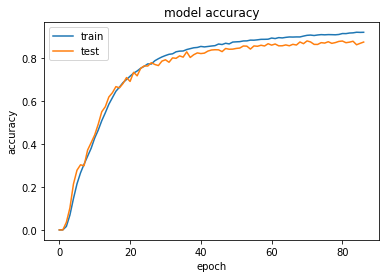

In [228]:
plt.plot(hist.history['predictions_nuclei_my_accuracy_score'])
plt.plot(hist.history['val_predictions_nuclei_my_accuracy_score'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

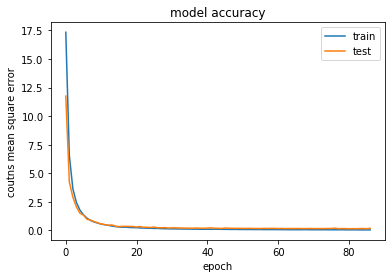

In [230]:
plt.plot(hist.history['predictions_counts_mean_squared_error'])
plt.plot(hist.history['val_predictions_counts_mean_squared_error'])
plt.title('model accuracy')
plt.ylabel('coutns mean square error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

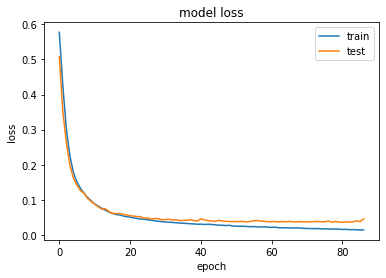

In [231]:
plt.plot(hist.history['predictions_nuclei_loss'])
plt.plot(hist.history['val_predictions_nuclei_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

# Validando nos espectros criados com Penelope

In [232]:
from keras.utils.vis_utils import plot_model

In [ ]:
#plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

191


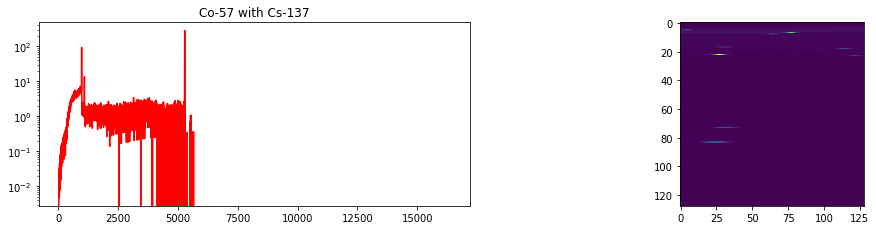

In [233]:
idx_ = np.random.choice(len(gerador_validacao) - 1, 1)[0]
print(idx_)
x_, aux_ = gerador_validacao[idx_]

y_counts = aux_['predictions_counts']
y_ = aux_['predictions_nuclei']

idx = 3
f, axarr = plt.subplots(1, 2, figsize=(17, 1.7))
axarr[0].plot(range(len(x_[idx].reshape(-1))),
              x_[idx].reshape(-1), 'r')
axarr[0].set_yscale("log")

axarr[0].set_title(" with ".join(binarizer.inverse_transform(np.array([y_[idx]]))[0]))
axarr[1].imshow(x_[0].reshape((128,128)))

plt.grid(False)
plt.subplots_adjust(bottom=1.25, top=2.75)
plt.show()

In [234]:
preds = model.predict(np.array([x_[idx].reshape((128, 128, 1))]))

In [236]:
df = pd.DataFrame({'radionuclideo':binarizer.classes_,
                   'nuclei_score': preds[0][0]*100,
                   #'nuclei_counts': scaler.inverse_transform(preds[1][0]),
                   'nuclei_counts': np.exp(preds[1][0]) - 1,
                   #'real_counts': scaler.inverse_transform(y_counts[idx])
                   'real_counts': np.exp(y_counts[idx]) - 1
                  })
df

,radionuclideo,nuclei_score,nuclei_counts,real_counts
0,Am-241,0.07,0.07,0.00
1,Ba-133,0.01,-0.04,0.00
2,Cd-109,0.57,-0.07,0.00
3,Co-57,99.86,"2,469.60","2,404.94"
4,Co-60,0.01,-0.03,0.00
5,Cs-137,99.98,"9,434.37","8,097.62"
6,Eu-152,0.02,-0.02,0.00
7,Mn-54,0.02,0.00,0.00
8,Na-22,0.01,0.02,0.00
9,Pb-210,0.93,-0.18,0.00


In [ ]:
# Criar uma massa de dados simulando com papel ao invés de água
# Corrigir as contagens na entrada pela eficiência da similação
# Re-treinar

# Validando nos espectros experimentais

In [237]:
def obtem_dados_dos_canais(linhas):
    dados = []
    pode_comecar = False
    for linha in linhas:
        if linha == "A004USERDEFINED                                                     \n":
            pode_comecar = True
            continue
        if pode_comecar:
            aux = linha.strip().split()
            if int(aux[1]) % 5:
                print("oi!")
            dados.extend([float(x) for x in aux[2:]])
    return dados[1:]

In [238]:
arquivos = ['Am-241 - BG.IEC',
            'Ba-133 - BG.IEC',
            'Cd-109 - BG.IEC',
            'Co-57 - BG.IEC',
            'Co-60 - BG.IEC',
            'Cs-137 - BG.IEC',
            'Eu-152 - BG.IEC',
            'Mn-54 - BG.IEC',
            'Na-22 - BG.IEC',
            'Pb-210 - BG.IEC',]

df_nuclideos = dict()
img_espectros = dict()
img_convertidos = dict()
images = dict()

for arquivo in arquivos:
    print(arquivo)
    dados = []

    with open('/export/ipen/artigo/ICDA-3/Espectros/Experimentos/17-Maio-2018/Espectros/{0}'.format(arquivo), 'r') as f:
        dados = f.readlines()
    dados = obtem_dados_dos_canais(dados)
    df = pd.DataFrame({'channel': range(0, len(dados)), 'counts' : dados})
    df_nuclideos[arquivo] = df.copy()
    img_convertidos[arquivo] = np.array(dados).reshape((128, 128)).copy()
    images[arquivo.split(' ')[0]] = np.array(dados).reshape((128, 128)).copy()

Am-241 - BG.IEC
Ba-133 - BG.IEC
Cd-109 - BG.IEC
Co-57 - BG.IEC
Co-60 - BG.IEC
Cs-137 - BG.IEC
Eu-152 - BG.IEC
Mn-54 - BG.IEC
Na-22 - BG.IEC
Pb-210 - BG.IEC


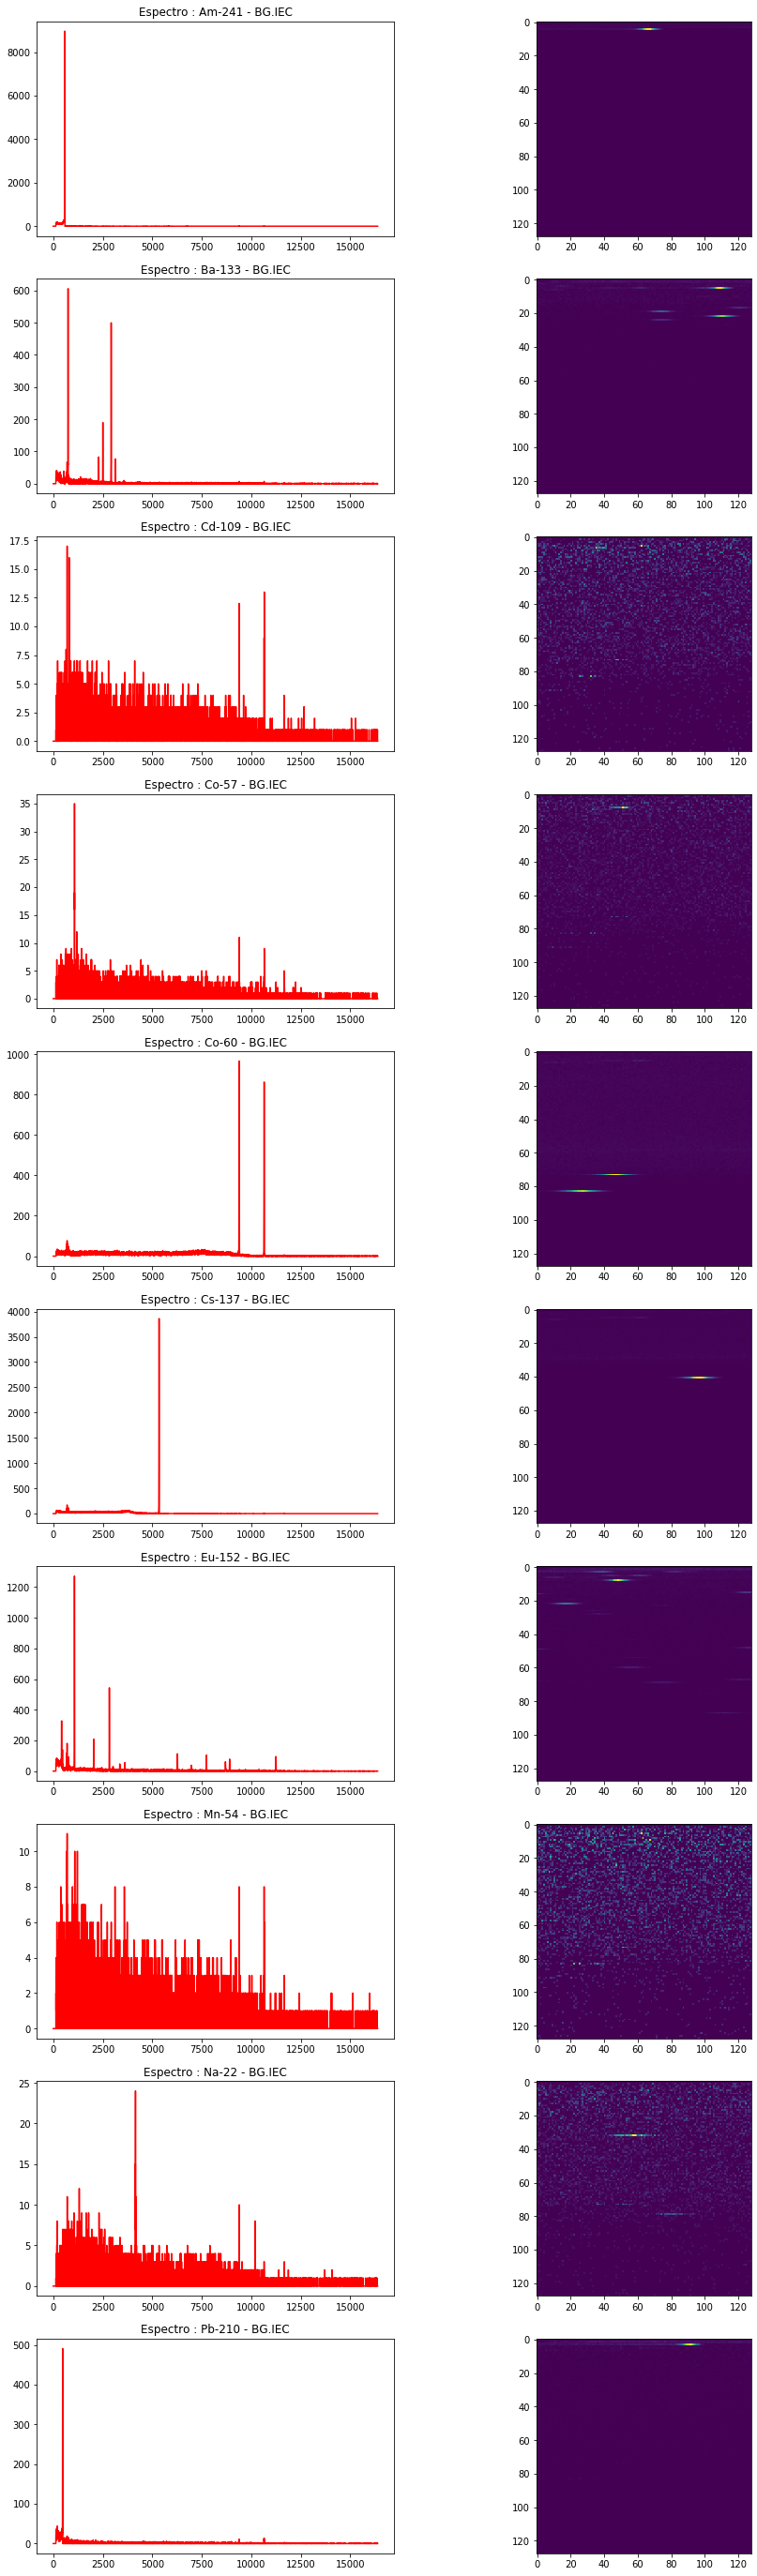

In [61]:
f, axarr = plt.subplots(10, 2, figsize=(15,25))
for n, arquivo in enumerate(arquivos):
    df = df_nuclideos[arquivo]
    axarr[n, 0].plot(df['channel'], df['counts'], 'r')
    axarr[n, 0].set_title("Espectro : {0}".format(arquivo))
    
    axarr[n, 1].imshow(img_convertidos[arquivo])
    #axarr[n, 1].set_title("Como Imagem : {0}".format(arquivo))
    
plt.grid(False)
plt.subplots_adjust(bottom=1.25, top=2.75)
plt.show()

In [239]:
preds = model.predict(np.array([images['Am-241'].reshape((128, 128, 1))]))

df = pd.DataFrame({'radionuclideo':binarizer.classes_,
                   'nuclei_score': preds[0][0]*100,
                   'nuclei_counts': scaler.inverse_transform(preds[1][0]),
                   'real_counts': np.sum(images['Am-241'])})
df

,radionuclideo,nuclei_score,nuclei_counts,real_counts
0,Am-241,100.00,"823,127.69","141,596.00"
1,Ba-133,0.01,"90,735.08","141,596.00"
2,Cd-109,1.62,"2,814.99","141,596.00"
3,Co-57,0.09,"9,222.78","141,596.00"
4,Co-60,0.01,"462,116.31","141,596.00"
5,Cs-137,0.00,"84,632.94","141,596.00"
6,Eu-152,0.01,"234,993.88","141,596.00"
7,Mn-54,0.01,"122,571.81","141,596.00"
8,Na-22,0.01,"415,236.88","141,596.00"
9,Pb-210,0.01,"1,258.32","141,596.00"


In [240]:
validation_nuclei = 'Ba-133'
preds = model.predict(np.array([images[validation_nuclei].reshape((128, 128, 1))]))

df = pd.DataFrame({'radionuclideo':binarizer.classes_,
                   'nuclei_score': preds[0][0]*100,
                   'nuclei_counts': scaler.inverse_transform(preds[1][0]),
                   'real_counts': np.sum(images[validation_nuclei])})
df

,radionuclideo,nuclei_score,nuclei_counts,real_counts
0,Am-241,0.00,"15,415.68","35,319.00"
1,Ba-133,99.98,"3,105,230.25","35,319.00"
2,Cd-109,0.01,"1,397.53","35,319.00"
3,Co-57,0.02,"26,244.65","35,319.00"
4,Co-60,0.01,"429,065.16","35,319.00"
5,Cs-137,0.04,"73,191.62","35,319.00"
6,Eu-152,0.01,"213,728.33","35,319.00"
7,Mn-54,0.02,"165,187.91","35,319.00"
8,Na-22,0.04,"398,643.62","35,319.00"
9,Pb-210,0.74,"1,841.02","35,319.00"


In [241]:
validation_nuclei = 'Cd-109'
preds = model.predict(np.array([images[validation_nuclei].reshape((128, 128, 1))]))

df = pd.DataFrame({'radionuclideo':binarizer.classes_,
                   'nuclei_score': preds[0][0]*100,
                   'nuclei_counts': scaler.inverse_transform(preds[1][0]),
                   'real_counts': np.sum(images[validation_nuclei])})
df

,radionuclideo,nuclei_score,nuclei_counts,real_counts
0,Am-241,0.00,"12,133.89","7,195.00"
1,Ba-133,0.02,"92,495.63","7,195.00"
2,Cd-109,100.00,"93,466.34","7,195.00"
3,Co-57,0.04,"22,801.04","7,195.00"
4,Co-60,0.27,"328,643.28","7,195.00"
5,Cs-137,0.00,"79,648.91","7,195.00"
6,Eu-152,0.02,"158,533.81","7,195.00"
7,Mn-54,0.03,"143,511.61","7,195.00"
8,Na-22,0.05,"358,520.91","7,195.00"
9,Pb-210,0.08,747.64,"7,195.00"


In [242]:
validation_nuclei = 'Co-57'
preds = model.predict(np.array([images[validation_nuclei].reshape((128, 128, 1))]))

df = pd.DataFrame({'radionuclideo':binarizer.classes_,
                   'nuclei_score': preds[0][0]*100,
                   'nuclei_counts': scaler.inverse_transform(preds[1][0]),
                   'real_counts': np.sum(images[validation_nuclei])})
df

,radionuclideo,nuclei_score,nuclei_counts,real_counts
0,Am-241,0.01,"16,694.33","7,323.00"
1,Ba-133,0.00,"94,648.72","7,323.00"
2,Cd-109,1.35,"1,173.87","7,323.00"
3,Co-57,100.00,"864,844.44","7,323.00"
4,Co-60,0.01,"358,064.97","7,323.00"
5,Cs-137,0.08,"74,512.23","7,323.00"
6,Eu-152,0.02,"232,981.58","7,323.00"
7,Mn-54,0.01,"190,367.64","7,323.00"
8,Na-22,0.03,"401,275.69","7,323.00"
9,Pb-210,0.54,"1,440.26","7,323.00"


In [243]:
validation_nuclei = 'Co-60'
preds = model.predict(np.array([images[validation_nuclei].reshape((128, 128, 1))]))

df = pd.DataFrame({'radionuclideo':binarizer.classes_,
                   'nuclei_score': preds[0][0]*100,
                   'nuclei_counts': scaler.inverse_transform(preds[1][0]),
                   'real_counts': np.sum(images[validation_nuclei])})
df

,radionuclideo,nuclei_score,nuclei_counts,real_counts
0,Am-241,0.00,"11,185.57","155,643.00"
1,Ba-133,0.01,"77,951.68","155,643.00"
2,Cd-109,0.12,"3,460.28","155,643.00"
3,Co-57,0.03,"34,596.07","155,643.00"
4,Co-60,100.00,"18,110,504.00","155,643.00"
5,Cs-137,0.00,"83,228.28","155,643.00"
6,Eu-152,0.02,"248,631.56","155,643.00"
7,Mn-54,0.05,"150,720.95","155,643.00"
8,Na-22,0.12,"488,439.00","155,643.00"
9,Pb-210,0.18,"1,512.06","155,643.00"


In [244]:
validation_nuclei = 'Cs-137'
preds = model.predict(np.array([images[validation_nuclei].reshape((128, 128, 1))]))

df = pd.DataFrame({'radionuclideo':binarizer.classes_,
                   'nuclei_score': preds[0][0]*100,
                   'nuclei_counts': scaler.inverse_transform(preds[1][0]),
                   'real_counts': np.sum(images[validation_nuclei])})
df

,radionuclideo,nuclei_score,nuclei_counts,real_counts
0,Am-241,0.00,"18,817.38","188,461.00"
1,Ba-133,0.08,"94,517.04","188,461.00"
2,Cd-109,0.00,"1,642.45","188,461.00"
3,Co-57,0.07,"26,247.11","188,461.00"
4,Co-60,0.00,"427,285.69","188,461.00"
5,Cs-137,99.99,"2,718,699.00","188,461.00"
6,Eu-152,0.03,"256,254.91","188,461.00"
7,Mn-54,0.02,"186,553.81","188,461.00"
8,Na-22,0.04,"424,418.12","188,461.00"
9,Pb-210,0.08,"1,393.85","188,461.00"


In [245]:
validation_nuclei = 'Eu-152'
preds = model.predict(np.array([images[validation_nuclei].reshape((128, 128, 1))]))

df = pd.DataFrame({'radionuclideo':binarizer.classes_,
                   'nuclei_score': preds[0][0]*100,
                   'nuclei_counts': scaler.inverse_transform(preds[1][0]),
                   'real_counts': np.sum(images[validation_nuclei])})
df

,radionuclideo,nuclei_score,nuclei_counts,real_counts
0,Am-241,0.01,"16,228.50","94,419.00"
1,Ba-133,0.04,"91,612.58","94,419.00"
2,Cd-109,0.12,"2,339.72","94,419.00"
3,Co-57,0.06,"24,589.65","94,419.00"
4,Co-60,0.00,"394,794.56","94,419.00"
5,Cs-137,0.08,"90,869.63","94,419.00"
6,Eu-152,99.99,"8,666,264.00","94,419.00"
7,Mn-54,0.02,"152,919.19","94,419.00"
8,Na-22,0.02,"242,000.64","94,419.00"
9,Pb-210,0.12,"1,452.51","94,419.00"


In [247]:
validation_nuclei = 'Mn-54'
preds = model.predict(np.array([images[validation_nuclei].reshape((128, 128, 1))]))

df = pd.DataFrame({'radionuclideo':binarizer.classes_,
                   'nuclei_score': preds[0][0]*100,
                   'nuclei_counts': scaler.inverse_transform(preds[1][0]),
                   'real_counts': np.sum(images[validation_nuclei])})
df

,radionuclideo,nuclei_score,nuclei_counts,real_counts
0,Am-241,0.01,"16,410.81","7,159.00"
1,Ba-133,0.02,"95,461.69","7,159.00"
2,Cd-109,0.19,"1,740.02","7,159.00"
3,Co-57,0.02,"26,327.62","7,159.00"
4,Co-60,0.03,"442,954.59","7,159.00"
5,Cs-137,0.01,"73,534.33","7,159.00"
6,Eu-152,0.04,"206,160.80","7,159.00"
7,Mn-54,99.80,"5,555,550.50","7,159.00"
8,Na-22,0.05,"558,089.56","7,159.00"
9,Pb-210,1.30,"1,863.82","7,159.00"


In [249]:
validation_nuclei = 'Na-22'
preds = model.predict(np.array([images[validation_nuclei].reshape((128, 128, 1))]))

df = pd.DataFrame({'radionuclideo':binarizer.classes_,
                   'nuclei_score': preds[0][0]*100,
                   'nuclei_counts': scaler.inverse_transform(preds[1][0]),
                   'real_counts': np.sum(images[validation_nuclei])})
df

,radionuclideo,nuclei_score,nuclei_counts,real_counts
0,Am-241,0.00,"12,609.98","7,965.00"
1,Ba-133,0.00,"69,244.99","7,965.00"
2,Cd-109,0.06,"2,542.56","7,965.00"
3,Co-57,0.08,"25,392.70","7,965.00"
4,Co-60,0.02,"414,597.22","7,965.00"
5,Cs-137,0.01,"82,832.86","7,965.00"
6,Eu-152,0.10,"202,173.58","7,965.00"
7,Mn-54,0.02,"173,165.66","7,965.00"
8,Na-22,99.66,"14,484,443.00","7,965.00"
9,Pb-210,0.82,"1,766.90","7,965.00"


In [250]:
validation_nuclei = 'Pb-210'
preds = model.predict(np.array([images[validation_nuclei].reshape((128, 128, 1))]))

df = pd.DataFrame({'radionuclideo':binarizer.classes_,
                   'nuclei_score': preds[0][0]*100,
                   'nuclei_counts': scaler.inverse_transform(preds[1][0]),
                   'real_counts': np.sum(images[validation_nuclei])})
df

,radionuclideo,nuclei_score,nuclei_counts,real_counts
0,Am-241,2.35,"22,208.30","19,650.00"
1,Ba-133,0.37,"88,010.53","19,650.00"
2,Cd-109,0.02,"2,055.04","19,650.00"
3,Co-57,0.34,"26,384.69","19,650.00"
4,Co-60,0.01,"449,840.31","19,650.00"
5,Cs-137,0.01,"72,444.04","19,650.00"
6,Eu-152,0.01,"224,881.17","19,650.00"
7,Mn-54,0.03,"146,768.81","19,650.00"
8,Na-22,0.01,"417,311.44","19,650.00"
9,Pb-210,100.00,"154,660.28","19,650.00"


## Fonte triplice de calibração

In [251]:
dados = []

with open('/export/ipen/artigo/ICDA-3/Espectros/Experimentos/17-Maio-2018/Espectros/Am-Cs-Co - BG.IEC', 'r') as f:
    dados = f.readlines()
dados = obtem_dados_dos_canais(dados)
df_triplice = pd.DataFrame({'channel': range(0, len(dados)), 'counts' : dados})

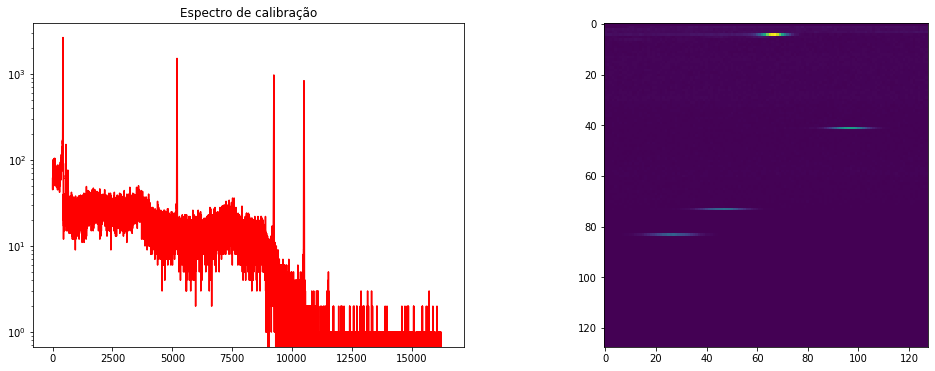

In [252]:
f, axarr = plt.subplots(1, 2, figsize=(17, 3))
axarr[0].plot(df_triplice['channel'], df_triplice.counts.shift(-145).fillna(0).values, 'r')
axarr[0].set_title("Espectro de calibração")
axarr[0].set_yscale("log")
axarr[1].imshow(np.array(dados).reshape((128,128)))

plt.grid(False)
plt.subplots_adjust(bottom=1.25, top=2.75)
plt.show()

In [253]:
shift_ = 0
dados = df_triplice.counts.shift(shift_).fillna(0).values

preds = model.predict(np.array([dados.reshape((128, 128, 1))]))

df = pd.DataFrame({'radionuclideo':binarizer.classes_,
                   'nuclei_score': preds[0][0]*100,
                   'nuclei_counts': scaler.inverse_transform(preds[1][0]),
                   'real_counts': np.sum(dados)})
df

,radionuclideo,nuclei_score,nuclei_counts,real_counts
0,Am-241,100.00,"739,068.38","276,428.00"
1,Ba-133,0.02,"164,922.41","276,428.00"
2,Cd-109,19.25,"10,032.12","276,428.00"
3,Co-57,0.19,"39,637.36","276,428.00"
4,Co-60,99.98,"18,078,384.00","276,428.00"
5,Cs-137,98.14,"2,500,024.75","276,428.00"
6,Eu-152,0.00,"149,800.31","276,428.00"
7,Mn-54,0.02,"271,828.47","276,428.00"
8,Na-22,0.01,"432,375.31","276,428.00"
9,Pb-210,0.00,"-2,296.85","276,428.00"


# Validando a atividade com um espectro simulado

In [254]:
[x for x in files if x.find('56cm')]

['../dados_v5/Cs-137_41cm_1-0e08estories_-1.dat',
 '../dados_v5/Eu-152_46cm_1-0e08estories_-1.dat',
 '../dados_v5/Co-57_51cm_1-0e08estories_-1.dat',
 '../dados_v5/Co-57_46cm_1-0e08estories_-1.dat',
 '../dados_v5/Eu-152_56cm_1-0e08estories_-1.dat',
 '../dados_v5/Am-241_56cm_1-0e08estories_-1.dat',
 '../dados_v5/Co-60_56cm_1-0e08estories_-1.dat',
 '../dados_v5/Am-241_41cm_1-0e08estories_-1.dat',
 '../dados_v5/Pb-210_41cm_1-0e08estories_-1.dat',
 '../dados_v5/Co-60_46cm_1-0e08estories_-1.dat',
 '../dados_v5/Na-22_46cm_1-0e08estories_-1.dat',
 '../dados_v5/Cs-137_56cm_1-0e08estories_-1.dat',
 '../dados_v5/Cd-109_56cm_1-0e08estories_-1.dat',
 '../dados_v5/Eu-152_41cm_1-0e08estories_-1.dat',
 '../dados_v5/Pb-210_56cm_1-0e08estories_-1.dat',
 '../dados_v5/Mn-54_46cm_1-0e08estories_-1.dat',
 '../dados_v5/Na-22_56cm_1-0e08estories_-1.dat',
 '../dados_v5/Cd-109_51cm_1-0e08estories_-1.dat',
 '../dados_v5/Cs-137_46cm_1-0e08estories_-1.dat',
 '../dados_v5/Co-60_51cm_1-0e08estories_-1.dat',
 '../dad

In [438]:
df_am241 = carrega_dados('../dados_v5/Am-241_46cm_1-0e08estories_-1.dat', 1e8)

/home/andre/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [439]:
!cat ../dados_v5/Am-241_46cm_1-0e08estories_-1.dat

#>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
# [SECTION REPORT PULSE HEIGHT SPECTRUM2]
# Units are 1/eV per history
#
# Detection material:
#  4
# Number of energy bins:
#  16384
# Energy bin width (eV):
#   1.25689E+02
#
# For plotting purposes, two values per energy bin are given, namely, the low end and the middle point of each bin.
#
# Elow(eV) : Emiddle(eV) : counts(1/eV/hist) : +-2sigma : nbin
  0.00000E+00  6.28444E+01  0.00000E+00  0.0E+00 1
  1.25689E+02  1.88533E+02  0.00000E+00  0.0E+00 2
  2.51378E+02  3.14222E+02  0.00000E+00  0.0E+00 3
  3.77067E+02  4.39911E+02  0.00000E+00  0.0E+00 4
  5.02756E+02  5.65600E+02  0.00000E+00  0.0E+00 5
  6.28444E+02  6.91289E+02  0.00000E+00  0.0E+00 6
  7.54133E+02  8.16978E+02  0.00000E+00  0.0E+00 7
  8.79822E+02  9.42667E+02  0.00000E+00  0.0E+00 8
  1.00551E+03  1.06836E+03  0.00000E+00  0.0E+00 9
  1.13120E+03  1.19404E+03  0.00000E+00  0.0E+00 10
  1.25689E+03  1.31973E+03  0.00000E+00  0.0E+00 11
  1.38258E+03  1.

  1.19065E+06  1.19071E+06  0.00000E+00  0.0E+00 9474
  1.19078E+06  1.19084E+06  0.00000E+00  0.0E+00 9475
  1.19090E+06  1.19097E+06  0.00000E+00  0.0E+00 9476
  1.19103E+06  1.19109E+06  0.00000E+00  0.0E+00 9477
  1.19115E+06  1.19122E+06  0.00000E+00  0.0E+00 9478
  1.19128E+06  1.19134E+06  0.00000E+00  0.0E+00 9479
  1.19140E+06  1.19147E+06  0.00000E+00  0.0E+00 9480
  1.19153E+06  1.19159E+06  0.00000E+00  0.0E+00 9481
  1.19166E+06  1.19172E+06  0.00000E+00  0.0E+00 9482
  1.19178E+06  1.19184E+06  0.00000E+00  0.0E+00 9483
  1.19191E+06  1.19197E+06  0.00000E+00  0.0E+00 9484
  1.19203E+06  1.19210E+06  0.00000E+00  0.0E+00 9485
  1.19216E+06  1.19222E+06  0.00000E+00  0.0E+00 9486
  1.19228E+06  1.19235E+06  0.00000E+00  0.0E+00 9487
  1.19241E+06  1.19247E+06  0.00000E+00  0.0E+00 9488
  1.19254E+06  1.19260E+06  0.00000E+00  0.0E+00 9489
  1.19266E+06  1.19272E+06  0.00000E+00  0.0E+00 9490
  1.19279E+06  1.19285E+06  0.00000E+00  0.0E+00 9491
  1.19291E+06  1.19298E+06  

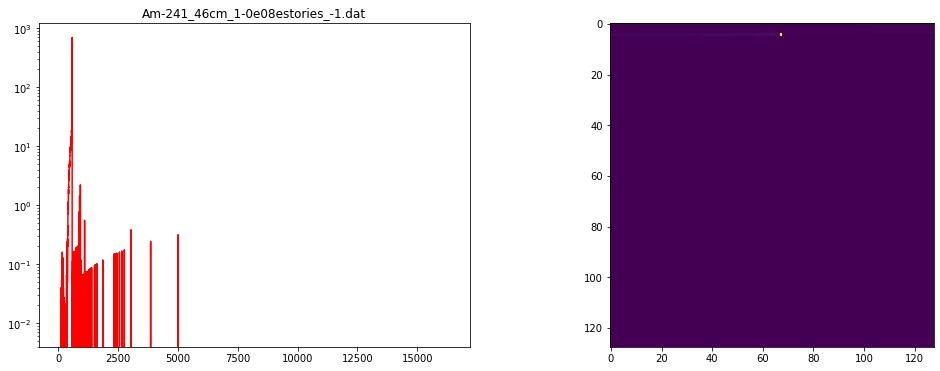

In [440]:
f, axarr = plt.subplots(1, 2, figsize=(17, 3))
axarr[0].plot(df_am241['nbin'], df_am241.counts.values, 'r')
axarr[0].set_title("Am-241_46cm_1-0e08estories_-1.dat")
axarr[0].set_yscale("log")
axarr[1].imshow(np.array(df_am241.counts.values).reshape((128,128)))

plt.grid(False)
plt.subplots_adjust(bottom=1.25, top=2.75)
plt.show()

In [442]:
np.argmax(df_am241.counts.values)

579

In [443]:
np.sum(df_am241.counts.values[579-5:579+5])

807.689611662647

In [390]:
# Performance report
#   Random seeds:
#   1518110056
#    232606248
#   No. of histories simulated [N]:
#           100000000.
#   CPU time [t] (s):
#    7.03350E+02
#   Speed (histories/s):
#    1.42177E+05
#   Average uncertainty (above 1/2 max score) in % [uncert]:
#    1.45326E+00
#   Intrinsic efficiency [N*uncert^2]^-1:
#    4.73490E-09
#   Absolute efficiency [t*uncert^2]^-1:
#    6.73192E-04

In [446]:
preds = model.predict(np.array([df_am241.counts.values.reshape((128, 128, 1))]))

df = pd.DataFrame({'radionuclideo':binarizer.classes_,
                   'nuclei_score': preds[0][0]*100,
                   'nuclei_counts': np.exp(preds[1][0]),
                   'real_counts': np.sum(df_am241.counts.values)})
df = df.set_index('radionuclideo')
df

,nuclei_score,nuclei_counts,real_counts
radionuclideo,,,
Am-241,100.00,"2,876.29","2,203.19"
Ba-133,0.00,1.00,"2,203.19"
Cd-109,1.67,0.97,"2,203.19"
Co-57,0.52,1.01,"2,203.19"
Co-60,0.02,1.03,"2,203.19"
Cs-137,0.02,0.99,"2,203.19"
Eu-152,0.02,1.02,"2,203.19"
Mn-54,0.03,1.00,"2,203.19"
Na-22,0.03,0.97,"2,203.19"


In [447]:
from scipy.signal import find_peaks

In [456]:
largura = 350

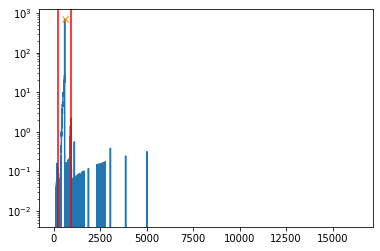

In [457]:
peaks, _ = find_peaks(df_am241.counts.values, prominence=2e1)
plt.plot(df_am241.counts.values)
plt.plot(peaks, df_am241.counts[peaks], "x")
plt.plot(np.zeros_like(df_am241.counts), "--", color="gray")

plt.axvline(peaks[0]-largura, 0, 1e4, label='pyplot vertical line', color="red")
plt.axvline(peaks[0]+largura, 0, 1e4, label='pyplot vertical line', color="red")

plt.yscale("log")
plt.show()

In [458]:
values = []
for idx, peak in enumerate(peaks):
    print(idx)
    data_aux = df_am241[peak-(largura+1*idx):peak+(largura+1*idx)]
    values.append(np.trapz(data_aux['counts'], data_aux['nbin']))
values, np.sum(values)

0


([2193.5404807415443], 2193.5404807415443)

In [459]:
def print_formatado(x):
    return "{:4.4e}".format(x)

In [463]:
eff = np.sum(values) / 1e8
print_formatado(eff)

'2.1935e-05'

In [465]:
atividade = df.loc['Am-241'].nuclei_counts / eff
print_formatado(atividade), atividade / 1e8

('1.3113e+08', 1.3112561551902135)

## Para Co-60

In [466]:
df_co60 = carrega_dados('../dados_v5/Co-60_56cm_1-0e08estories_-1.dat', 1e8)

/home/andre/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [467]:
!cat ../dados_v5/Co-60_56cm_1-0e08estories_-1.dat

#>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
# [SECTION REPORT PULSE HEIGHT SPECTRUM2]
# Units are 1/eV per history
#
# Detection material:
#  4
# Number of energy bins:
#  16384
# Energy bin width (eV):
#   1.25689E+02
#
# For plotting purposes, two values per energy bin are given, namely, the low end and the middle point of each bin.
#
# Elow(eV) : Emiddle(eV) : counts(1/eV/hist) : +-2sigma : nbin
  0.00000E+00  6.28444E+01  0.00000E+00  0.0E+00 1
  1.25689E+02  1.88533E+02  0.00000E+00  0.0E+00 2
  2.51378E+02  3.14222E+02  0.00000E+00  0.0E+00 3
  3.77067E+02  4.39911E+02  0.00000E+00  0.0E+00 4
  5.02756E+02  5.65600E+02  0.00000E+00  0.0E+00 5
  6.28444E+02  6.91289E+02  0.00000E+00  0.0E+00 6
  7.54133E+02  8.16978E+02  0.00000E+00  0.0E+00 7
  8.79822E+02  9.42667E+02  0.00000E+00  0.0E+00 8
  1.00551E+03  1.06836E+03  0.00000E+00  0.0E+00 9
  1.13120E+03  1.19404E+03  0.00000E+00  0.0E+00 10
  1.25689E+03  1.31973E+03  0.00000E+00  0.0E+00 11
  1.38258E+03  1.

  1.08620E+06  1.08627E+06  3.73939E-09  1.1E-09 8643
  1.08633E+06  1.08639E+06  5.25106E-09  1.3E-09 8644
  1.08645E+06  1.08652E+06  5.88755E-09  1.4E-09 8645
  1.08658E+06  1.08664E+06  5.41018E-09  1.3E-09 8646
  1.08671E+06  1.08677E+06  6.20580E-09  1.4E-09 8647
  1.08683E+06  1.08689E+06  5.88755E-09  1.4E-09 8648
  1.08696E+06  1.08702E+06  5.09194E-09  1.3E-09 8649
  1.08708E+06  1.08715E+06  5.64887E-09  1.3E-09 8650
  1.08721E+06  1.08727E+06  4.93281E-09  1.3E-09 8651
  1.08733E+06  1.08740E+06  6.28536E-09  1.4E-09 8652
  1.08746E+06  1.08752E+06  5.17150E-09  1.3E-09 8653
  1.08759E+06  1.08765E+06  5.01238E-09  1.3E-09 8654
  1.08771E+06  1.08777E+06  6.04668E-09  1.4E-09 8655
  1.08784E+06  1.08790E+06  5.41018E-09  1.3E-09 8656
  1.08796E+06  1.08803E+06  5.64887E-09  1.3E-09 8657
  1.08809E+06  1.08815E+06  6.52405E-09  1.4E-09 8658
  1.08821E+06  1.08828E+06  4.69413E-09  1.2E-09 8659
  1.08834E+06  1.08840E+06  4.77369E-09  1.2E-09 8660
  1.08847E+06  1.08853E+06  

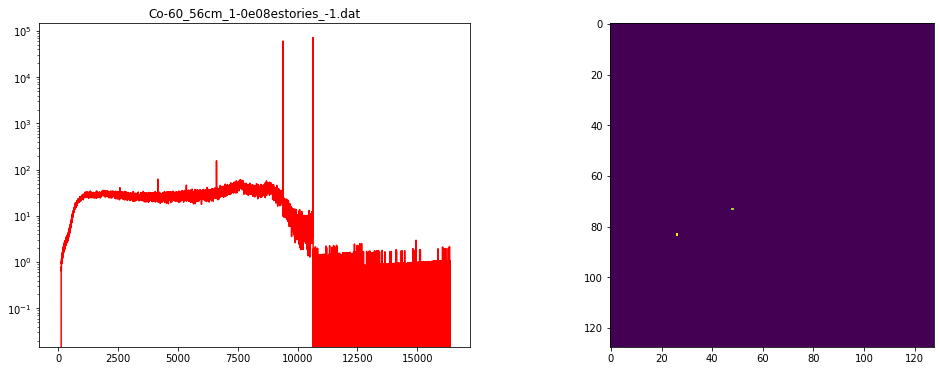

In [468]:
f, axarr = plt.subplots(1, 2, figsize=(17, 3))
axarr[0].plot(df_co60['nbin'], df_co60.counts.values, 'r')
axarr[0].set_title("Co-60_56cm_1-0e08estories_-1.dat")
axarr[0].set_yscale("log")
axarr[1].imshow(np.array(df_co60.counts.values).reshape((128,128)))

plt.grid(False)
plt.subplots_adjust(bottom=1.25, top=2.75)
plt.show()

In [469]:
preds = model.predict(np.array([df_co60.counts.values.reshape((128, 128, 1))]))

df = pd.DataFrame({'radionuclideo':binarizer.classes_,
                   'nuclei_score': preds[0][0]*100,
                   'nuclei_counts': np.exp(preds[1][0]),
                   'real_counts': np.sum(df_co60.counts.values)})
df = df.set_index("radionuclideo")
df

,nuclei_score,nuclei_counts,real_counts
radionuclideo,,,
Am-241,0.00,0.93,"413,587.11"
Ba-133,0.01,0.99,"413,587.11"
Cd-109,0.11,1.11,"413,587.11"
Co-57,0.02,0.99,"413,587.11"
Co-60,100.00,"450,984.34","413,587.11"
Cs-137,0.02,1.04,"413,587.11"
Eu-152,0.03,1.02,"413,587.11"
Mn-54,0.11,1.01,"413,587.11"
Na-22,0.03,0.99,"413,587.11"


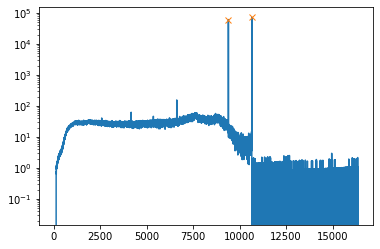

In [471]:
peaks, _ = find_peaks(df_co60.counts.values, prominence=2e3)
plt.plot(df_co60.counts.values)
plt.plot(peaks, df_co60.counts[peaks], "x")
plt.plot(np.zeros_like(df_co60.counts), "--", color="gray")
plt.yscale("log")
plt.show()

In [477]:
largura = 450
values = []
for idx, peak in enumerate(peaks):
    print(idx)
    data_aux = df_co60[peak-(largura+1*idx):peak+(largura+1*idx)]
    values.append(np.trapz(data_aux['counts'], data_aux['nbin']))
values, np.sum(values)

eff = np.mean(np.array(values)) / 1e8
eff, values

0
1


(0.0007730151506341052, [79198.69070473113, 75404.33942208992])

In [478]:
values, np.array(values) / 1e8

([79198.69070473113, 75404.33942208992], array([0.00079199, 0.00075404]))

In [479]:
atividade = df.loc['Co-60']['nuclei_counts'] / eff
atividade, atividade / 1e8

(583409449.84074, 5.834094498407399)